Load modules/packages.

In [1]:
import pkg_resources
import pygam
import pandas
import numpy
import numpy.random
import seaborn
import matplotlib.pyplot as plt
import vtreat
import vtreat.util
import wvpy.util

pkg_resources.get_distribution("vtreat").version

'0.2.3'

Generate example data. `y` is a noisy sin function. Input `xc` is a categorical variable that represents a discretization of `y`. The output to be predicted is `yc`: whether `y` is > 0.5. 

In [2]:
d = pandas.DataFrame({'x':[0.1*i for i in range(500)]})
d['y'] = numpy.sin(d['x']) + 0.1*numpy.random.normal(size=d.shape[0])
d['xc'] = ['level_' + str(5*numpy.round(yi/5, 1)) for yi in d['y']]
d.loc[d['xc']=='level_-1.0', 'xc'] = numpy.nan # introduce a nan level
d['yc'] = d['y']>0.5
d.head()

,x,y,xc,yc
0,0.0,-0.028765,level_-0.0,False
1,0.1,0.025191,level_0.0,False
2,0.2,0.233559,level_0.0,False
3,0.3,0.175831,level_0.0,False
4,0.4,0.435625,level_0.5,False


In [3]:
d['xc'].unique()

array(['level_-0.0', 'level_0.0', 'level_0.5', 'level_1.0', 'level_-0.5',
       nan, 'level_1.5'], dtype=object)

In [4]:
d['xc'].value_counts(dropna=False)

NaN           110
level_1.0     108
level_0.5     100
level_-0.5     98
level_0.0      43
level_-0.0     40
level_1.5       1
Name: xc, dtype: int64

In [5]:
numpy.mean(d['yc'])

0.334

Plot of `yc` versus `x`.

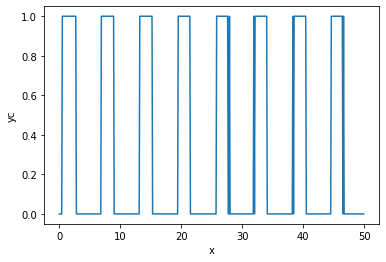

In [6]:
seaborn.lineplot(x='x', y='yc', data=d)

## Build a classification model.

First create the data treatment transform object, in this case a treatment for a binomial classification problem.

In [7]:
transform = vtreat.BinomialOutcomeTreatment(
    outcome_name='yc',    # outcome variable
    outcome_target=True,  # outcome of interest
    cols_to_copy=['y'])   # columns to "carry along" but not treat as input variables

Use the training data 'd' to fit the transform and the return a treated training set: completely numeric, with no missing values.
Note that `transform.fit_transform()` is **not** the same as `transform.fit().transform()`; the second call can lead to nested model bias in some situations, and is **not** recommended.

In [8]:
d_prepared = transform.fit_transform(d, d['yc'])
d_prepared.head()

,y,yc,xc_is_bad,x,xc_logit_code,xc_prevalence_code,xc_lev__NA_,xc_lev_level_1.0,xc_lev_level_0.5,xc_lev_level_-0.5
0,-0.028765,False,0.0,0.0,-5.780128,0.078,0,0,0,0
1,0.025191,False,0.0,0.1,-5.777739,0.084,0,0,0,0
2,0.233559,False,0.0,0.2,-5.740770,0.084,0,0,0,0
3,0.175831,False,0.0,0.3,-5.792510,0.084,0,0,0,0
4,0.435625,False,0.0,0.4,0.543934,0.198,0,0,1,0


Note that the variable `xc` has been converted to multiple variables: an indicator variable for each possible level (`xc_lev_level_*`); the value of a (cross-validated) one-variable model for `yc` as a function of `xc` (`xc_logit_code`); and a variable indicating how prevalent this particular value of `xc` is in the training data. Any or all of these new variables are available for downstream modeling.

Now examine the score frame, which gives information about each new variable, including its type, which original variable it is  derived from, its (cross-validated) correlation with the outcome, and its (cross-validated) significance as a one-variable model for the outcome. Variables that are significant to **what level??** are marked as "recommended" for use in downstream modeling. In this case, all the variables appear significant. ***Note for John: why is x recommended? It's not significant, and shouldn't be. For that matter, why is prevalence significant here?***

In [9]:
transform.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
0,xc_is_bad,xc,missing_indicator,False,True,-0.376097,3.022918e-18,1.0,True
1,x,x,clean_copy,False,True,-0.085273,5.671904e-02,1.0,True
2,xc_logit_code,xc,logit_code,True,True,0.849835,1.273773e-140,1.0,True
3,xc_prevalence_code,xc,prevalence_code,False,True,0.320971,1.914417e-13,1.0,True
4,xc_lev__NA_,xc,indicator_code,False,True,-0.376097,3.022918e-18,4.0,True
5,xc_lev_level_1.0,xc,indicator_code,False,True,0.741195,3.044493e-88,4.0,True
6,xc_lev_level_0.5,xc,indicator_code,False,True,0.260792,3.226469e-09,4.0,True
7,xc_lev_level_-0.5,xc,indicator_code,False,True,-0.349652,7.979417e-16,4.0,True


Let's see if `xc_logit_code` makes a good one-variable model. It has a large AUC:

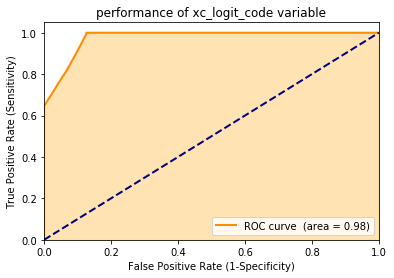

0.9763535991080902

In [10]:
wvpy.util.plot_roc(prediction=d_prepared['xc_logit_code'], 
                   istrue=d_prepared['yc'],
                   title = 'performance of xc_logit_code variable')

Negative values of `xc_logit_code` correspond strongly to negative outcomes, and positive values correspond strongly to postive outcomes.

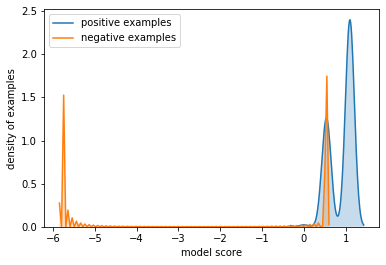

In [11]:
wvpy.util.dual_density_plot(probs=d_prepared['xc_logit_code'], 
                            istrue=d_prepared['yc'])

Try converting the logistic score to a probability.

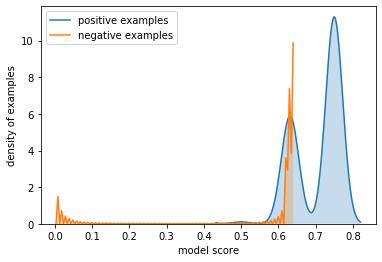

In [12]:
from scipy.special import expit  # sigmoid - remarkably, it works on Pandas data frame columns
wvpy.util.dual_density_plot(probs=expit(d_prepared['xc_logit_code']),
                            istrue=d_prepared['yc'])                                   

Look at `xc_prevalence_code`. It's also somewhat predictive (surprisingly).

First, get the contingency table of prevalence code value versus outcome value. The two variables are clearly not independent.

In [13]:
pandas.crosstab(d_prepared.xc_prevalence_code, d_prepared.yc)

yc,False,True
xc_prevalence_code,,
0.000,0,1
0.078,40,0
0.084,43,0
0.194,98,0
0.198,42,58
0.214,0,108
0.218,110,0


Next, look at the AUC and the distribution of scores graphically.

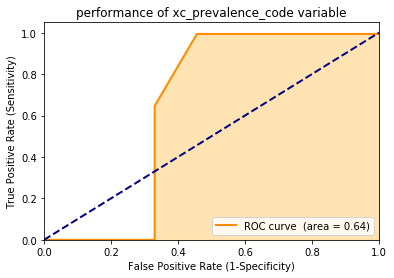

0.6437575299850749

In [14]:
wvpy.util.plot_roc(prediction=d_prepared['xc_prevalence_code'], 
                   istrue=d_prepared['yc'],
                   title = 'performance of xc_prevalence_code variable')

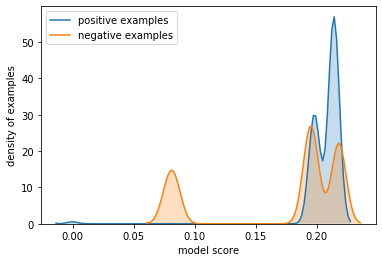

In [15]:
wvpy.util.dual_density_plot(probs=d_prepared['xc_prevalence_code'], 
                            istrue=d_prepared['yc'])